# Evaluation

## Calculate Metrics
Implement as script to run in parallel (`get_metrics` or `get_metrics_for_method`)

In [1]:
from glob import glob, iglob
from itertools import chain, product
from json import dump, load
from os import makedirs
from os.path import isfile, join
from typing import Optional

from cairosvg import svg2png
import numpy as np
import pandas as pd
from PIL import Image  # TODO: replace with PIL-SIMD
from scipy.stats import mannwhitneyu, iqr, shapiro
from svgpathtools import Path, Line, QuadraticBezier, CubicBezier, disvg, svg2paths
from matplotlib import pyplot as plt

In [2]:
def one_is_endpoint(intersection, tol=.1):
    i = intersection
    return i[0] < tol or i[0] > 1 - tol \
        or i[1] < tol or i[1] > 1 - tol \

def calculate_intersections(paths, path_attributes=None, ignore_color : Optional[str] =None):
    no_overlapping = 0
    check_color = path_attributes is not None and ignore_color is not None
    for i, path1 in enumerate(paths):
        # Skip white patches
        if check_color and Color(path_attributes[i].get("stroke")) == Color(ignore_color):
            continue
        for j in range(i + 1, len(paths)):
            if check_color and Color(path_attributes[j].get("stroke")) == Color(ignore_color):
                continue
            path2 = paths[j]
            if path1 == path2:
                no_overlapping += 1
            try:
                intersections = path1.intersect(path2)
            except (AssertionError, ValueError):
                continue
            if len(intersections) > 1:
                all_endpoint = all(one_is_endpoint(i) for i in intersections)
                if not all_endpoint:
                    no_overlapping += 1
    return no_overlapping

def resolve_path(path, recursive=True):
    if type(path) in [Line, QuadraticBezier, CubicBezier]:
        yield path
    elif type(path) is Path:
        if not recursive:
            if len(path._segments) == 1:
                segment = next(iter(path))
                yield segment
        else:
            for segment in iter(path):
                yield segment
    else:
        yield path


def resolve_all_paths(paths, recursive=True):
    return list(chain(*(resolve_path(path, recursive=recursive) for path in paths)))

In [3]:
output_dir = "/scratch/cmetzger/outputs"  # TODO: change to correct
eval_metrics = "../eval_metrics"
report = "../report"
figures = join(report, "figures")
tables = join(report, "tables")
methods = ["autotrace", "polyvector-flow", "virtual-sketching", "deepvectechdraw", "marked"]
test_subsets = ["tonari", "sketchbench"]
resolutions = ["512-0.512", "1024-1.024"]
p = 0.05

In [4]:
def iou(a, b):
    intersection = np.logical_and(a, b)
    union = np.logical_or(a, b)
    iou_score = intersection.sum() / union.sum()
    return iou_score

def extract_curves_from_svg(svg_filename):
    paths = svg2paths(svg_filename)[0]
    curves = resolve_all_paths(paths, recursive=True)
    return curves


def curves_to_points_array(curves):
    points_iter = chain(*(curve.bpoints() for curve in curves))
    points = np.array([(point.real, point.imag) for point in points_iter])
    points = points.reshape((-1, 4, 2))
    return points


def get_raster_difference(png_file, gt_png_file):
    image = Image.open(png_file, formats=("png",)).convert(mode="1")
    gt_image = Image.open(gt_png_file, formats=("png",)).convert(mode="1")
    image = np.asarray(image)
    gt_image = np.asarray(gt_image)
    diff = iou(~image, ~gt_image)
    return diff


def get_curve_error(curves, gt_curves):
    points = curves_to_points_array(curves)
    gt_points = curves_to_points_array(gt_curves)
    combination_indices = np.array(list(product(range(points.shape[0]), range(gt_points.shape[0]))))
    points_samples = points[combination_indices[:, 0]]
    gt_points_samples = gt_points[combination_indices[:, 1]]
    rss = np.abs(points_samples - gt_points_samples).sum(axis=(1, 2))
    rss = rss.reshape(points.shape[0], gt_points.shape[0])
    min_rss = rss.min(axis=1)
    return min_rss


def get_hole_distance(curves):
    startpoints = chain(curve.start for curve in curves)
    endpoints = chain(curve.end for curve in curves)
    #points_array = np.array([((startpoint.real, startpoint.imag), (endpoint.real, endpoint.imag)) for startpoint, endpoint in zip(startpoints, endpoints)])
    startpoints_array = np.array([(startpoint.real, startpoint.imag) for startpoint in startpoints])
    endpoints_array = np.array([(endpoint.real, endpoint.imag) for endpoint in endpoints])
    dist = np.full((startpoints_array.shape[0], startpoints_array.shape[0]), np.inf)
    triu1, triu2 = np.triu_indices(startpoints_array.shape[0], k=1)  # k=1 to not calculate distance with identical point
    startpoint_dist = np.linalg.norm(startpoints_array[triu1] - startpoints_array[triu2], ord=1, axis=1)
    endpoint_dist = np.linalg.norm(startpoints_array[triu1] - endpoints_array[triu2], ord=1, axis=1)
    dist[triu1, triu2] = np.minimum(startpoint_dist, endpoint_dist)
    min_dist = dist.min(axis=1)
    min_dist = min_dist[:dist.shape[0] - 1]  # remove last element, as it is not compared with any other element
    min_dist = min_dist[min_dist < 50]
    return min_dist


def calculate_svg_metrics(method, test_subset, resolution, binarized):
    svg_dir = join(output_dir, method, "svg", "binarized" if binarized else "", resolution)
    svg_files = sorted(iglob(join(svg_dir, test_subset + "*.svg")))
    metrics = {
        "curve distance": [],
        "curve error": [],
        # "overlapping curves": [],
        "iou": [],
        "curve ratio": [],
        "curve length": [],
    }
    for svg_file in svg_files:
        curves = extract_curves_from_svg(svg_file)
        curves += extract_curves_from_svg(svg_file)
        curves = extract_curves_from_svg(svg_file)
        avg_curve_len = np.median([curve.length() for curve in curves])
        metrics["curve length"].append(avg_curve_len)
        holes = get_hole_distance(curves)
        metrics["curve distance"].append(holes.sum())
        gt_svg_file = svg_file.replace(method, "ground-truth")
        gt_curves = extract_curves_from_svg(gt_svg_file)
        metrics["curve ratio"].append(len(curves) / len(gt_curves))
        errors = get_curve_error(curves, gt_curves)
        metrics["curve error"].append(np.median(errors))
        #no_overlapping = calculate_intersections(curves)
        #metrics["overlapping curves"].append(no_overlapping)
    png_files = sorted(iglob(join(svg_dir, test_subset + "-*.png")))
    for png_file in png_files:
        gt_png_file = png_file.replace(method, "ground-truth")
        sim = get_raster_difference(png_file, gt_png_file)
        metrics["iou"].append(sim)
    return metrics
        
    
def get_runtimes(method, test_subset, resolution, binarized, output_dir=output_dir):
    runtimes = []
    runtime_dir = join(output_dir, method, "runtime", "binarized" if binarized else "", resolution)
    for runtime_file in sorted(glob(join(runtime_dir, test_subset + "-*.txt"))):
        with open(runtime_file, "r") as txt_file:
            runtime = txt_file.read()
        if runtime.startswith("Command exited with non-zero status"):
            continue
        user_idx = runtime.find("user")
        system_idx = runtime.find("system")
        user_seconds = float(runtime[0:user_idx])
        system_seconds = float(runtime[user_idx + len("user "):system_idx])
        runtimes.append(user_seconds + system_seconds)
    return runtimes

def get_metrics_for_method(method, test_subset, resolution, binarized):
    runtimes = get_runtimes(method, test_subset, resolution, binarized)
    svg_metrics = calculate_svg_metrics(method, test_subset, resolution, binarized)
    return {"runtime": runtimes, **svg_metrics}

def get_metrics(methods, test_subset, resolution, binarized):
    result = {}
    for method in methods:
        result[method] = get_metrics_for_method(method, test_subset, resolution, binarized)
    return result

def get_gt_metrics(test_subset, resolution, binarized):
    metrics = {}
    svg_dir = join(output_dir, "ground-truth", "svg", "binarized" if binarized else "", resolution)
    svg_files = sorted(iglob(join(svg_dir, test_subset + "*.svg")))
    metrics = {
        "curves": [],
        # "overlapping curves": [],
        "curve distance": [],
        "curve length": [],
    }
    for svg_file in svg_files:
        curves = extract_curves_from_svg(svg_file)
        metrics["curves"].append(len(curves))
        avg_curve_len = np.median([curve.length() for curve in curves])
        metrics["curve length"].append(avg_curve_len)
        holes = get_hole_distance(curves)
        metrics["curve distance"].append(holes.sum())
    return metrics

In [5]:
for test_subset in test_subsets:
    for binarized in [True, False]:
        for resolution in resolutions:
            eval_dir_path = join(eval_metrics, test_subset, "binarized" if binarized else "", resolution)
            eval_filename = join(eval_dir_path, "metrics.json")
            if isfile(eval_filename):
                continue
            makedirs(eval_dir_path, exist_ok=True)
            metrics = get_metrics(methods, test_subset, resolution, binarized)
            with open(eval_filename, "w") as eval_file:
                dump(metrics, eval_file)

In [6]:
for test_subset in test_subsets:
    for binarized in [True, False]:
        for resolution in resolutions:
            eval_dir_path = join(eval_metrics, test_subset, "binarized" if binarized else "", resolution)
            eval_filename = join(eval_dir_path, "gt_metrics.json")
            if isfile(eval_filename) and False:
                continue
            makedirs(eval_dir_path, exist_ok=True)
            metrics = get_gt_metrics(test_subset, resolution, binarized)
            with open(eval_filename, "w") as eval_file:
                dump(metrics, eval_file)

## Calculate summaries

Iterate through `eval_dir`, iterate through each json, calculate median and iqr for each list, save summary json

In [7]:
def summarize_metrics_for_method(metrics):
    metrics["curve ratio"] = np.median(metrics["curve ratio"])
    metrics["runtime"] = np.median(metrics["runtime"])
    metrics["curve distance"] = np.median(metrics["curve distance"])
    metrics["curve error"] = np.median(metrics["curve error"])
    metrics["iou"] = np.median(metrics["iou"])
    return metrics

def summarize_metrics_for_method(metrics):
    output = {
        "iou": {
            "median": np.median(metrics["iou"]),
            "\\acrshort{iqr}": iqr(metrics["iou"]),
        },
        "curve ratio": {
            "median": np.median(metrics["curve ratio"]),
            "\\acrshort{iqr}": iqr(metrics["curve ratio"]),
        },
        "curve length": {
            "median": np.median(metrics["curve length"]),
            "\\acrshort{iqr}": iqr(metrics["curve length"]),
        },
        "curve distance": {
            "median": np.median(metrics["curve distance"]),
            "\\acrshort{iqr}": iqr(metrics["curve distance"]),
        },
        "curve error": {
            "median": np.median(metrics["curve error"]),
            "\\acrshort{iqr}": iqr(metrics["curve error"]),
        },
        "runtime": {
            "median": np.median(metrics["runtime"]),
            "\\acrshort{iqr}": iqr(metrics["runtime"]),
        },
    }
    return output


def summarize_metrics_for_method_tuples(metrics):
    output = {
        ("\\acrshort{iou} $\\uparrow$", "median"): np.median(metrics["iou"]),
        ("\\acrshort{iou} $\\uparrow$", "\\acrshort{iqr}"): iqr(metrics["iou"]),
        ("curve ratio", "median"): np.median(metrics["curve ratio"]),
        ("curve ratio", "\\acrshort{iqr}"): iqr(metrics["curve ratio"]),
        ("curve length", "median"): np.median(metrics["curve length"]),
        ("curve length", "\\acrshort{iqr}"): iqr(metrics["curve length"]),
        ("curve distance", "median"): np.median(metrics["curve distance"]),
        ("curve distance", "\\acrshort{iqr}"): iqr(metrics["curve distance"]),
        ("curve error $\\downarrow$", "median"): np.median(metrics["curve error"]),
        ("curve error $\\downarrow$", "\\acrshort{iqr}"): iqr(metrics["curve error"]),
        ("runtime $\\downarrow$", "median"): np.median(metrics["runtime"]),
        ("runtime $\\downarrow$", "\\acrshort{iqr}"): iqr(metrics["runtime"]),
    }
    return output

def summarize_metrics_for_gt_tuples(metrics):
    output = {
        ("curves", "median"): np.median(metrics["curves"]),
        ("curves", "\\acrshort{iqr}"): iqr(metrics["curves"]),
        ("curve length", "median"): np.median(metrics["curve length"]),
        ("curve length", "\\acrshort{iqr}"): iqr(metrics["curve length"]),
        ("curve distance", "median"): np.median(metrics["curve distance"]),
        ("curve distance", "\\acrshort{iqr}"): iqr(metrics["curve distance"]),
    }
    return output


def summarize_metrics(metrics, tuples=False):
    for method in metrics.keys():
        if tuples:
            metrics[method] = summarize_metrics_for_method_tuples(metrics[method])
        else:
            metrics[method] = summarize_metrics_for_method(metrics[method])
    return metrics

In [8]:
for test_subset in test_subsets:
    for binarized in [True, False]:
        for resolution in resolutions:
            eval_dir_path = join(eval_metrics, test_subset, "binarized" if binarized else "", resolution)
            eval_filename = join(eval_dir_path, "metrics.json")
            summary_filename = join(eval_dir_path, "summary.json")
            if not isfile(eval_filename):
                continue
            with open(eval_filename, "r") as metrics_file:
                metrics = load(metrics_file)
            summary = summarize_metrics(metrics)
            with open(summary_filename, "w") as summary_file:
                dump(summary, summary_file)

## Visualization
Iterate through `eval_dir`, read every summary json, export as latex table, some matplotlib plots

In [46]:
def highligh_best(df, k, higher=True):
    if higher:
        best, second = df[k].nlargest(2)
    else:
        best, second = df[k].nsmallest(2)
    df[k] = df[k].apply(lambda x: "\\textbf{" + "{:.2f}".format(x) + "}" if x == best else ("\\textit{" + "{:.2f}".format(x) + "}" if x == second else x))
    return

def highligh_all_best(df):
    for k in df.columns:
        if k[1] == "\\acrshort{iqr}":
            continue
        if "$\\uparrow$" in k[0]:
            highligh_best(df, k, higher=True)
        if "$\\downarrow$" in k[0]:
            highligh_best(df, k, higher=False)

def break_method_name(name):
    par_width = "5em" if name == "polyvector-flow" else "4em"
    if name == "deepvectechdraw":
        return "\\parbox[]{" + par_width + "}{deepvec-\\\\techdraw}"
    elif "-" in name:
        split_idx = name.find("-")
        return "\\parbox[]{" + par_width + "}{" + name[:split_idx] + "-\\\\"  + name[split_idx + 1:] + "}"
    else:
        return str(name)

In [48]:
dfs = {}
summaries = {}
all_metrics = {}
for test_subset in test_subsets:
    summaries[test_subset] = {}
    dfs[test_subset] = {}
    all_metrics[test_subset] = {}
    for binarized in [True, False]:
        summaries[test_subset][binarized] = {}
        dfs[test_subset][binarized] = {}
        all_metrics[test_subset][binarized] = {}
        for resolution in resolutions:
            eval_dir_path = join(eval_metrics, test_subset, "binarized" if binarized else "", resolution)
            eval_filename = join(eval_dir_path, "metrics.json")
            summary_filename = join(eval_dir_path, "summary.json")
            if not isfile(eval_filename):
                continue
            with open(eval_filename, "r") as metrics_file:
                metrics = load(metrics_file)
            with open(summary_filename, "r") as summary_file:
                summary = load(summary_file)
            all_metrics[test_subset][binarized][resolution] = metrics.copy()
            summaries[test_subset][binarized][resolution] = summary
            summary = summarize_metrics(metrics, tuples=True)
            columns = pd.MultiIndex.from_tuples(summary[list(summary.keys())[0]].keys())
            # TODO: maybe replace method name with ref
            df = pd.DataFrame.from_dict(summary, orient="index", columns=columns)
            highligh_all_best(df)
            df.index.name = "method"
            dfs[test_subset][binarized][resolution] = df
            latex_filename = join(tables, f"{test_subset}-{binarized}-{resolution}.tex")
            with open(latex_filename, "w") as tex_file:
                df_tex = df.T.copy()
                df_tex.columns = [break_method_name(k) for k in df.T.columns]
                df_tex.to_latex(buf=tex_file, float_format="%.2f")
            # df = pd.DataFrame.from_dict(summary, orient="index")

In [11]:
gt_dfs = []
gt_summaries = {}
for test_subset in test_subsets:
    for resolution in resolutions:
        eval_dir_path = join(eval_metrics, test_subset, resolution)
        eval_filename = join(eval_dir_path, "gt_metrics.json")
        if not isfile(eval_filename):
            continue
        with open(eval_filename, "r") as metrics_file:
            metrics = load(metrics_file)
        summary = summarize_metrics_for_gt_tuples(metrics)
        gt_summaries[(test_subset, resolution)] = summary

In [12]:
columns = pd.MultiIndex.from_tuples(gt_summaries[list(gt_summaries.keys())[0]].keys())
gt_df = pd.DataFrame.from_dict(gt_summaries, orient="index", columns=columns)
gt_df.index.name = ("test set", "resolution")
latex_filename = join(tables, "gt_metrics.tex")
with open(latex_filename, "w") as tex_file:
    gt_df.to_latex(buf=tex_file, float_format="%.2f", multicolumn_format="c")
gt_df

curves                curve length                 \
                       median \acrshort{iqr}       median \acrshort{iqr}   
tonari      512-0.512   205.0          423.0     2.562475       0.786232   
            1024-1.024  205.0          423.0     5.124949       1.572465   
sketchbench 512-0.512   208.0          266.0    12.427372      14.285707   
            1024-1.024  208.0          266.0    24.854744      28.571414   

                       curve distance                 
                               median \acrshort{iqr}  
tonari      512-0.512     1555.824000    1832.408000  
            1024-1.024    1725.813333    3489.328000  
sketchbench 512-0.512     2355.215810    1237.411465  
            1024-1.024    2726.027922    2330.494105

In [18]:
dfs["tonari"][False]["512-0.512"].T

method                                        autotrace polyvector-flow  \
\acrshort{iou} $\uparrow$ median               0.015302           0.125   
                          \acrshort{iqr}       0.009371        0.108183   
curve ratio               median               0.226667        1.354326   
                          \acrshort{iqr}       0.109376        1.084359   
curve length              median                    1.0        0.545506   
                          \acrshort{iqr}       0.414214        0.038854   
curve distance            median                  891.0        439.1771   
                          \acrshort{iqr}         1535.0       1126.0224   
curve error $\downarrow$  median              20.365333  \textbf{14.05}   
                          \acrshort{iqr}      19.149333       14.643828   
runtime $\downarrow$      median          \textbf{0.35}           14.82   
                          \acrshort{iqr}          0.305           23.95   

method                                   virtual-sketching deepvectechdraw  \
\acrshort{iou} $\uparrow$ median             \textit{0.29}        0.283753   
                          \acrshort{iqr}          0.062585        0.069564   
curve ratio               median                    0.2966        0.192308   
                          \acrshort{iqr}          0.137063        0.132187   
curve length              median                 11.164404        9.061567   
                          \acrshort{iqr}          4.180127        2.097296   
curve distance            median               1442.910747        917.5037   
                          \acrshort{iqr}        1782.80256        974.0589   
curve error $\downarrow$  median                 20.083732          17.583   
                          \acrshort{iqr}          9.118634       10.028933   
runtime $\downarrow$      median                     22.99           97.73   
                          \acrshort{iqr}              7.34          72.205   

method                                            marked  
\acrshort{iou} $\uparrow$ median           \textbf{0.30}  
                          \acrshort{iqr}        0.046104  
curve ratio               median                0.430514  
                          \acrshort{iqr}        0.150481  
curve length              median                8.192088  
                          \acrshort{iqr}        2.451014  
curve distance            median             1361.281006  
                          \acrshort{iqr}       1498.0289  
curve error $\downarrow$  median          \textit{16.76}  
                          \acrshort{iqr}        5.355292  
runtime $\downarrow$      median           \textit{9.49}  
                          \acrshort{iqr}          13.175

In [390]:
def plot_marked_res_metric(ax, metric, test_subset="tonari", method="marked", binarized=False, normalize_res=False):
    metric_low = summaries[test_subset][binarized]["512-0.512"][method][metric]["median"]
    metric_low_iqr = summaries[test_subset][binarized]["512-0.512"][method][metric]["\\acrshort{iqr}"]
    metric_hi = summaries[test_subset][binarized]["1024-1.024"][method][metric]["median"]
    metric_hi_iqr = summaries[test_subset][binarized]["1024-1.024"][method][metric]["\\acrshort{iqr}"]
    metric_hi_dist = np.array(all_metrics[test_subset][binarized]["1024-1.024"][method][metric])
    if normalize_res:
        metric_hi /= 2
        metric_hi_iqr /= 2
        metric_hi_dist /= 2
    print(test_subset, metric, method, mannwhitneyu(all_metrics[test_subset][binarized]["512-0.512"][method][metric], metric_hi_dist))
    label = method
    linewidth = 3 if method == "marked" else 1
    capthick = 1.2
    plot_kwargs = {"capsize": 10, "capthick": capthick, "marker": "o", "linewidth": linewidth}
    ax.errorbar(["512", "1024"], [metric_low, metric_hi], yerr=[metric_low_iqr, metric_hi_iqr], label=label, **plot_kwargs)

def plot_marked_binarization_metric(ax, metric, test_subset="tonari", method="marked", resolution="512-0.512", lines=True):
    metric_low = summaries[test_subset][False][resolution][method][metric]["median"]
    metric_low_iqr = summaries[test_subset][False][resolution][method][metric]["\\acrshort{iqr}"]
    metric_hi = summaries[test_subset][True][resolution][method][metric]["median"]
    metric_hi_iqr = summaries[test_subset][True][resolution][method][metric]["\\acrshort{iqr}"]
    metric_hi_dist = np.array(all_metrics[test_subset][True][resolution][method][metric])
    print(test_subset, metric, method, mannwhitneyu(all_metrics[test_subset][False][resolution][method][metric], metric_hi_dist))
    label = method
    linewidth = 3 if method == "marked" else 1
    capthick = 1.2
    plot_kwargs = {"capsize": 10, "capthick": capthick, "marker": "o" if method == "marked" else ".", "linewidth": linewidth}
    ax.errorbar(["non-binarized", "binarized"], [metric_low, metric_hi], yerr=[metric_low_iqr, metric_hi_iqr], label=label, **plot_kwargs)

def plot_marked_metric(ax, metric, test_subset="tonari", method="marked", binarized=[False, True], resolution=["512-0.512", "1024-1.024"], normalize_res=False):
    metric_low = summaries[test_subset][binarized[0]][resolution[0]][method][metric]["median"]
    metric_low_iqr = summaries[test_subset][binarized[0]][resolution[0]][method][metric]["\\acrshort{iqr}"]
    metric_hi = summaries[test_subset][binarized[1]][resolution[1]][method][metric]["median"]
    metric_hi_iqr = summaries[test_subset][binarized[1]][resolution[1]][method][metric]["\\acrshort{iqr}"]
    metric_hi_dist = np.array(all_metrics[test_subset][binarized[1]][resolution[1]][method][metric])
    if normalize_res:
        metric_hi /= 2
        metric_hi_iqr /= 2
        metric_hi_dist /= 2
    print(test_subset, metric, method, mannwhitneyu(all_metrics[test_subset][binarized[0]][resolution[0]][method][metric], metric_hi_dist))
    label = method
    linewidth = 3 if method == "marked" else 1
    capthick = 1.2
    plot_kwargs = {"capsize": 10, "capthick": capthick, "marker": "o" if method == "marked" else ".", "linewidth": linewidth}
    ax.errorbar(["512px non-binarized", "1024px binarized"], [metric_low, metric_hi], yerr=[metric_low_iqr, metric_hi_iqr], label=label, **plot_kwargs)

tonari iou autotrace MannwhitneyuResult(statistic=469.5, pvalue=0.07057659289041077)
tonari iou polyvector-flow MannwhitneyuResult(statistic=0.0, pvalue=9.69797407628411e-10)
tonari iou virtual-sketching MannwhitneyuResult(statistic=0.0, pvalue=3.030868359795783e-10)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=90.0, pvalue=2.1351413721989603e-06)
tonari iou marked MannwhitneyuResult(statistic=183.0, pvalue=0.3519764902680531)


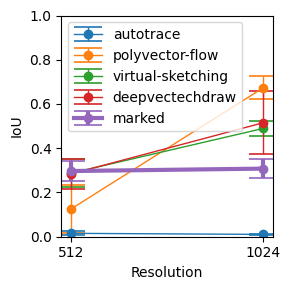

In [395]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    plot_marked_res_metric(ax, "iou", method=method, binarized=False)
ax.set_ylim(0, 1)
ax.set_ylabel("IoU")
ax.set_xlabel("Resolution")
ax.legend()
fig.tight_layout()
fig.savefig(join(figures, "iou_res.pdf"))

tonari runtime autotrace MannwhitneyuResult(statistic=0.0, pvalue=3.0121545916432007e-10)
tonari runtime polyvector-flow MannwhitneyuResult(statistic=96.0, pvalue=1.6664717167472657e-05)
tonari runtime virtual-sketching MannwhitneyuResult(statistic=111.0, pvalue=1.2038244666697715e-05)
tonari runtime deepvectechdraw MannwhitneyuResult(statistic=256.0, pvalue=0.06170669002831272)
tonari runtime marked MannwhitneyuResult(statistic=283.0, pvalue=1.0)


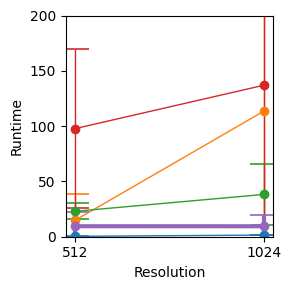

In [396]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    plot_marked_res_metric(ax, "runtime", method=method)
plt.ylim(0, 200)
ax.set_ylabel("Runtime")
ax.set_xlabel("Resolution")
# fig.legend()
fig.tight_layout()
fig.savefig(join(figures, "runtime_res.pdf"))

tonari curve ratio autotrace MannwhitneyuResult(statistic=182.5, pvalue=0.34548734710987816)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=68.0, pvalue=0.00013147852640642266)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=110.0, pvalue=0.005655195276783268)
tonari curve ratio marked MannwhitneyuResult(statistic=251.5, pvalue=0.44291436576092413)


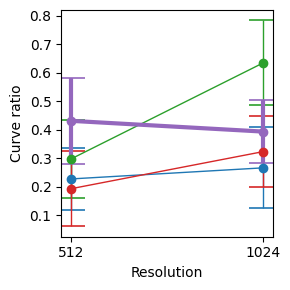

In [397]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    if method == "polyvector-flow":
        ax.plot([], label=method)
        continue
    plot_marked_res_metric(ax, "curve ratio", method=method)
ax.set_ylabel("Curve ratio")
ax.set_xlabel("Resolution")
# ax.legend()
fig.tight_layout()
fig.savefig(join(figures, "curve_ratio_res.pdf"))

tonari curve error autotrace MannwhitneyuResult(statistic=277.0, pvalue=0.15891754968522953)
tonari curve error polyvector-flow MannwhitneyuResult(statistic=153.0, pvalue=0.20845355458876536)
tonari curve error virtual-sketching MannwhitneyuResult(statistic=281.0, pvalue=0.13121079099148933)
tonari curve error deepvectechdraw MannwhitneyuResult(statistic=261.0, pvalue=0.3143051330541584)
tonari curve error marked MannwhitneyuResult(statistic=218.0, pvalue=0.9598741753513395)


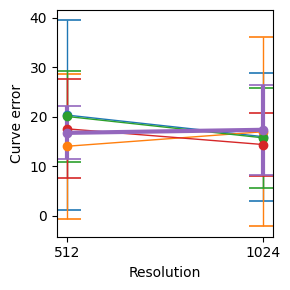

In [398]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    plot_marked_res_metric(ax, "curve error", method=method, normalize_res=True)
ax.set_ylabel("Curve error")
ax.set_xlabel("Resolution")
# ax.legend()
fig.tight_layout()
fig.savefig(join(figures, "curve_error_res.pdf"))

tonari curve length autotrace MannwhitneyuResult(statistic=441.0, pvalue=1.188188828969355e-08)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=400.0, pvalue=6.795615128173358e-08)
tonari curve length virtual-sketching MannwhitneyuResult(statistic=372.0, pvalue=0.00014556458323603704)
tonari curve length deepvectechdraw MannwhitneyuResult(statistic=260.0, pvalue=0.32655631642696226)
tonari curve length marked MannwhitneyuResult(statistic=229.0, pvalue=0.8405062858111236)


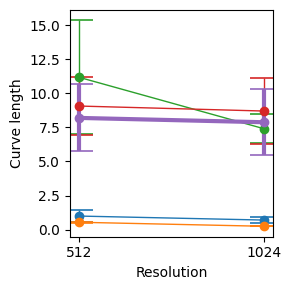

In [399]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    plot_marked_res_metric(ax, "curve length", method=method, normalize_res=True)
ax.set_ylabel("Curve length")
ax.set_xlabel("Resolution")
# ax.legend()
fig.tight_layout()
fig.savefig(join(figures, "curve_length_res.pdf"))

tonari curve distance autotrace MannwhitneyuResult(statistic=273.0, pvalue=0.1908399057704352)
tonari curve distance polyvector-flow MannwhitneyuResult(statistic=70.0, pvalue=0.0004600727270090418)
tonari curve distance virtual-sketching MannwhitneyuResult(statistic=196.0, pvalue=0.5460180023945915)
tonari curve distance deepvectechdraw MannwhitneyuResult(statistic=249.0, pvalue=0.48120815818423346)
tonari curve distance marked MannwhitneyuResult(statistic=278.0, pvalue=0.15160731211683598)


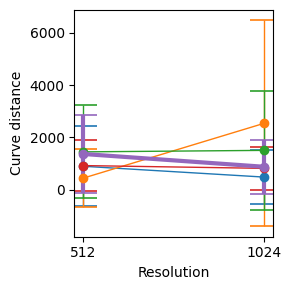

In [400]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
for method in methods:
    plot_marked_res_metric(ax, "curve distance", method=method, normalize_res=True)
ax.set_ylabel("Curve distance")
ax.set_xlabel("Resolution")
# ax.legend()
fig.tight_layout()
fig.savefig(join(figures, "curve_distance_res.pdf"))

sketchbench iou autotrace MannwhitneyuResult(statistic=407.0, pvalue=2.8832289101904107e-06)
sketchbench iou polyvector-flow MannwhitneyuResult(statistic=0.0, pvalue=3.125399998400872e-08)
sketchbench iou virtual-sketching MannwhitneyuResult(statistic=0.0, pvalue=3.125399998400872e-08)
sketchbench iou deepvectechdraw MannwhitneyuResult(statistic=0.0, pvalue=3.125399998400872e-08)
sketchbench iou marked MannwhitneyuResult(statistic=202.0, pvalue=0.6506903704105349)
sketchbench curve ratio autotrace MannwhitneyuResult(statistic=203.0, pvalue=0.6689077174430536)
sketchbench curve ratio virtual-sketching MannwhitneyuResult(statistic=48.0, pvalue=1.512999278143731e-05)
sketchbench curve ratio deepvectechdraw MannwhitneyuResult(statistic=131.0, pvalue=0.025164969815949612)
sketchbench curve ratio marked MannwhitneyuResult(statistic=234.0, pvalue=0.7436492622639466)
sketchbench curve length autotrace MannwhitneyuResult(statistic=441.0, pvalue=4.3461940189023396e-09)
sketchbench curve length p

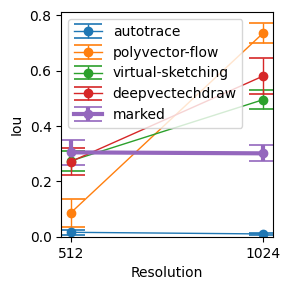

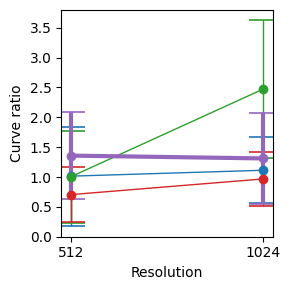

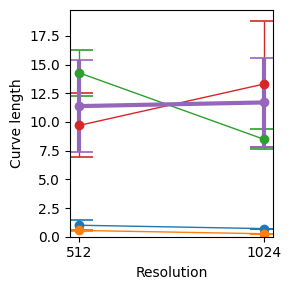

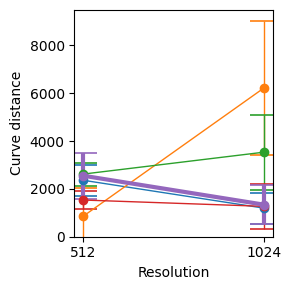

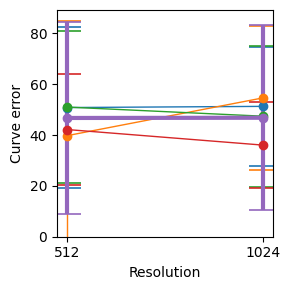

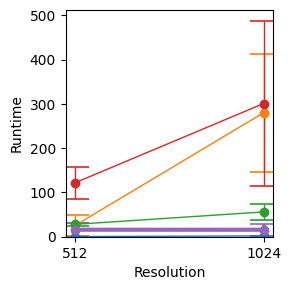

In [401]:
test_subset = "sketchbench"
binarized = False
for metric in summaries[test_subset][binarized]["512-0.512"][methods[0]].keys():
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    for method in methods:
        if metric == "curve ratio" and method == "polyvector-flow":
            ax.plot([], label=method)
            continue
        plot_marked_res_metric(ax, metric, test_subset, method, normalize_res=metric in ["curve distance", "curve error", "curve length"])
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Resolution")
    ax.set_ylim(0)
    if metric == "iou":
        ax.legend()
    fig.tight_layout()
    fig.savefig(join(figures, f"{metric}_res_{test_subset}.pdf"))

tonari iou autotrace MannwhitneyuResult(statistic=45.0, pvalue=3.41531183136026e-08)
tonari iou polyvector-flow MannwhitneyuResult(statistic=8.0, pvalue=1.637140853715411e-09)
tonari iou virtual-sketching MannwhitneyuResult(statistic=0.0, pvalue=3.030868359795783e-10)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=73.0, pvalue=4.793750445838785e-07)
tonari iou marked MannwhitneyuResult(statistic=194.0, pvalue=0.5130800796227113)
tonari curve ratio autotrace MannwhitneyuResult(statistic=119.0, pvalue=0.011062138508318366)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=99.0, pvalue=0.002335757906125647)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=77.0, pvalue=0.00032157358682115576)
tonari curve ratio marked MannwhitneyuResult(statistic=230.5, pvalue=0.8111139459191504)
tonari curve length autotrace MannwhitneyuResult(statistic=254.5, pvalue=0.3993674708644893)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=400.0, pvalue=6

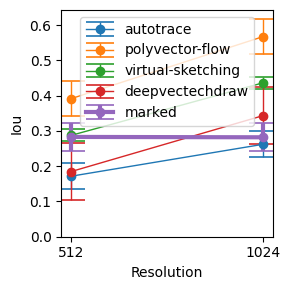

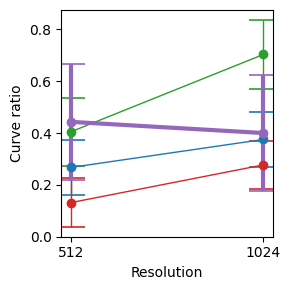

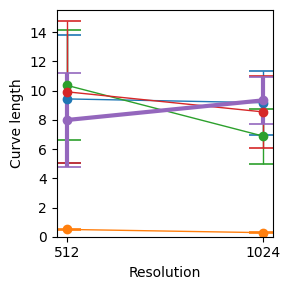

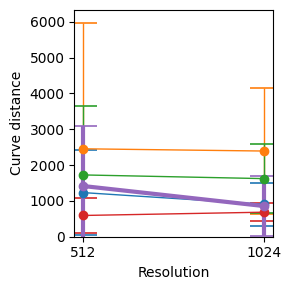

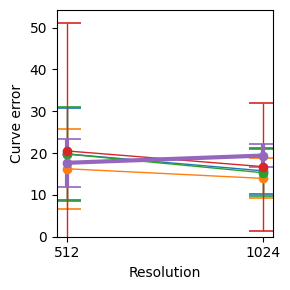

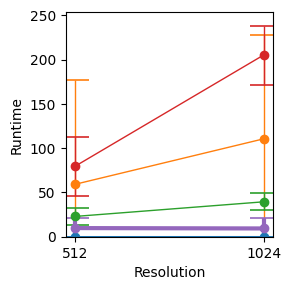

In [387]:
test_subset = "tonari"
binarized = True
for metric in summaries[test_subset][binarized]["512-0.512"][methods[0]].keys():
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot()
    for method in methods:
        if metric == "curve ratio" and method == "polyvector-flow":
            ax.plot([], label=method)
            continue
        plot_marked_res_metric(ax, metric, test_subset, method, binarized=binarized, normalize_res=metric in ["curve distance", "curve error", "curve length"])
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Resolution")
    ax.set_ylim(bottom=0)
    if metric == "iou":
        ax.legend()
    fig.tight_layout()
    fig.savefig(join(figures, f"{metric}_res_{test_subset}_{binarized}.pdf"))

tonari iou autotrace MannwhitneyuResult(statistic=0.0, pvalue=3.021498398468565e-10)
tonari iou polyvector-flow MannwhitneyuResult(statistic=5.0, pvalue=1.7431785750329323e-09)
tonari iou virtual-sketching MannwhitneyuResult(statistic=394.0, pvalue=0.6158790432108641)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=620.0, pvalue=1.0261992737267522e-05)
tonari iou marked MannwhitneyuResult(statistic=267.0, pvalue=0.24720534308664543)
tonari curve ratio autotrace MannwhitneyuResult(statistic=178.0, pvalue=0.29072107953069615)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=104.0, pvalue=0.0035220994912779705)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=316.0, pvalue=0.01685776486063875)
tonari curve ratio marked MannwhitneyuResult(statistic=209.0, pvalue=0.7819831594969533)
tonari curve length autotrace MannwhitneyuResult(statistic=0.0, pvalue=2.2105934600509165e-08)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=340.0, pval

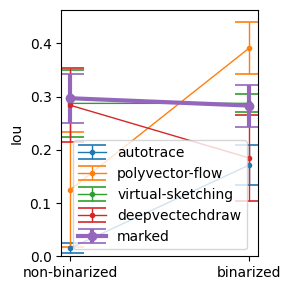

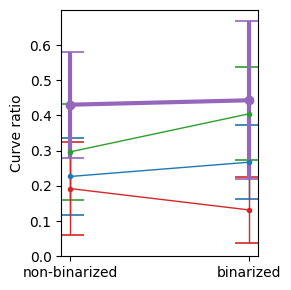

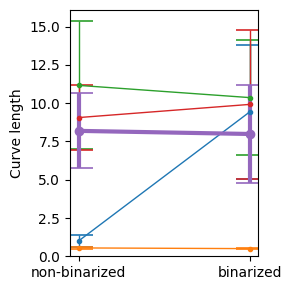

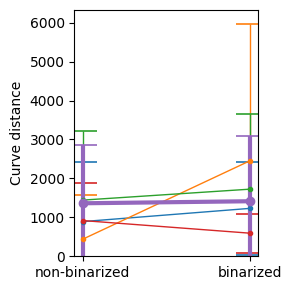

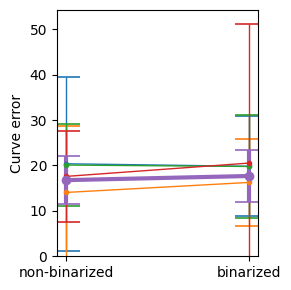

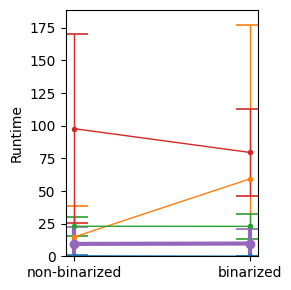

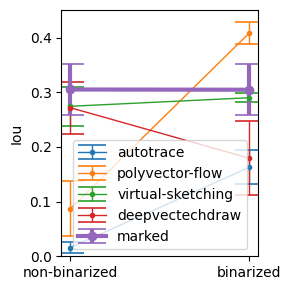

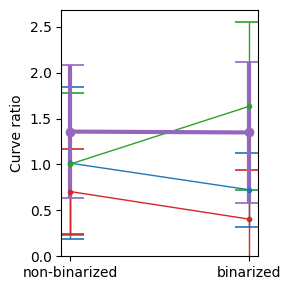

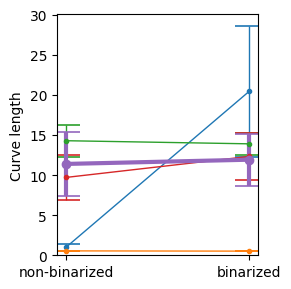

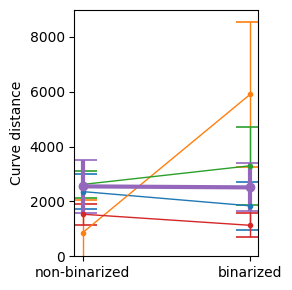

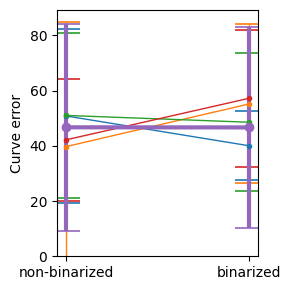

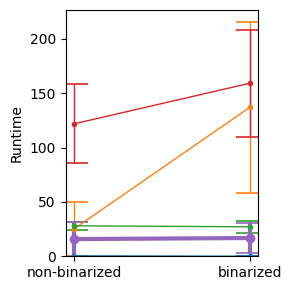

In [348]:
binarized = True
resolution = "512-0.512"
for test_subset in test_subsets:
    for metric in summaries[test_subset][True][resolution][methods[0]].keys():
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot()
        for method in methods:
            if metric == "curve ratio" and method == "polyvector-flow":
                ax.plot([], label=method)
                continue
            plot_marked_binarization_metric(ax, metric, test_subset, method, resolution=resolution)
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(bottom=0)
        if metric == "iou":
            ax.legend()
        fig.tight_layout()
        fig.savefig(join(figures, f"{metric}_binarization_{test_subset}.pdf"))

tonari iou autotrace MannwhitneyuResult(statistic=0.0, pvalue=3.021498398468565e-10)
tonari iou polyvector-flow MannwhitneyuResult(statistic=0.0, pvalue=9.69797407628411e-10)
tonari iou virtual-sketching MannwhitneyuResult(statistic=1.0, pvalue=3.388094287401544e-10)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=240.0, pvalue=0.0319370921407344)
tonari iou marked MannwhitneyuResult(statistic=237.0, pvalue=0.6873220903878915)
tonari curve ratio autotrace MannwhitneyuResult(statistic=99.0, pvalue=0.002335757906125647)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=49.5, pvalue=1.792956591137796e-05)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=148.0, pvalue=0.07010784129484465)
tonari curve ratio marked MannwhitneyuResult(statistic=227.0, pvalue=0.8800274316446192)
tonari curve length autotrace MannwhitneyuResult(statistic=0.0, pvalue=2.2105934600509165e-08)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=400.0, pvalue=6.79

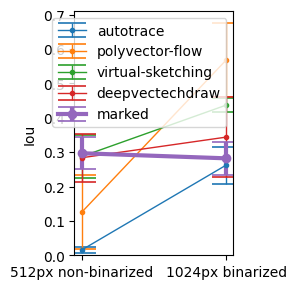

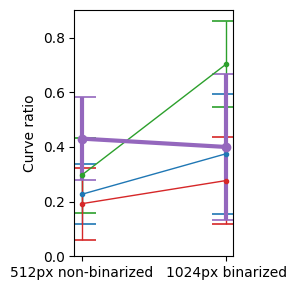

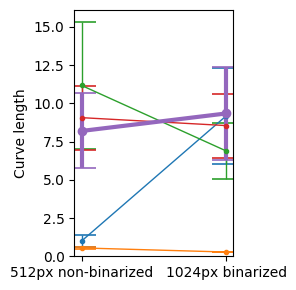

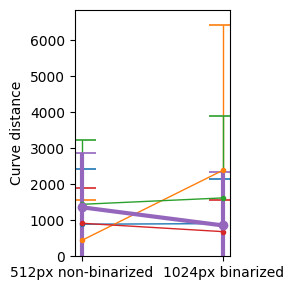

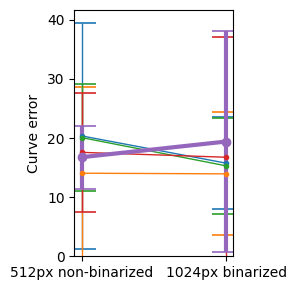

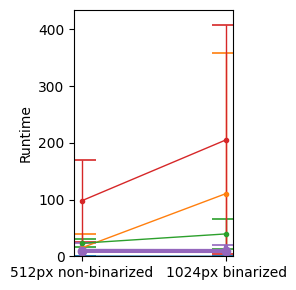

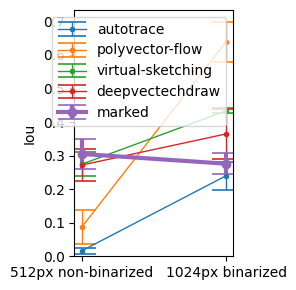

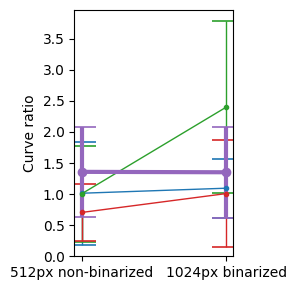

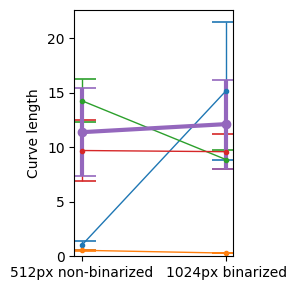

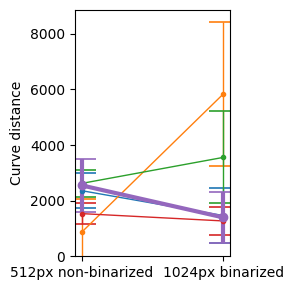

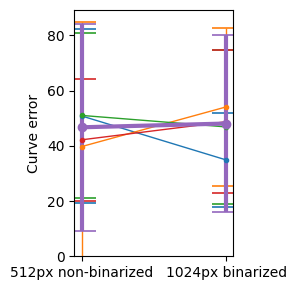

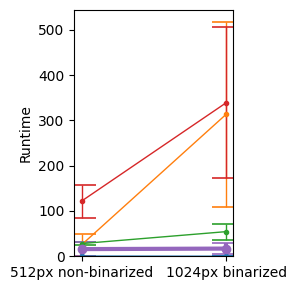

In [406]:
for test_subset in test_subsets:
    for metric in summaries[test_subset][True][resolution][methods[0]].keys():
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot()
        for method in methods:
            if metric == "curve ratio" and method == "polyvector-flow":
                ax.plot([], label=method)
                continue
            plot_marked_metric(ax, metric, test_subset, method, normalize_res=metric in ["curve distance", "curve error", "curve length"])
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(bottom=0)
        if metric == "iou":
            ax.legend()
        fig.tight_layout()
        fig.savefig(join(figures, f"{metric}_res_binarization_{test_subset}.pdf"))

tonari iou autotrace MannwhitneyuResult(statistic=0.0, pvalue=3.030868359795783e-10)
tonari iou polyvector-flow MannwhitneyuResult(statistic=602.0, pvalue=1.4186698101940057e-06)
tonari iou virtual-sketching MannwhitneyuResult(statistic=702.0, pvalue=5.539679472062115e-09)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=627.0, pvalue=5.8263775059921024e-06)
tonari iou marked MannwhitneyuResult(statistic=276.0, pvalue=0.16649147398308384)
tonari curve ratio autotrace MannwhitneyuResult(statistic=126.0, pvalue=0.018047625262461266)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=166.0, pvalue=0.17433363250882716)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=261.0, pvalue=0.3143051330541584)
tonari curve ratio marked MannwhitneyuResult(statistic=204.0, pvalue=0.6872980899620332)
tonari curve length autotrace MannwhitneyuResult(statistic=0.0, pvalue=1.7250159305314184e-08)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=85.0, pv

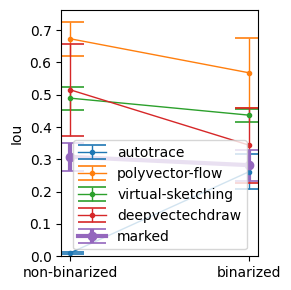

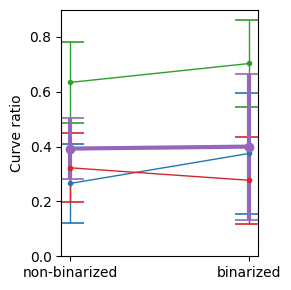

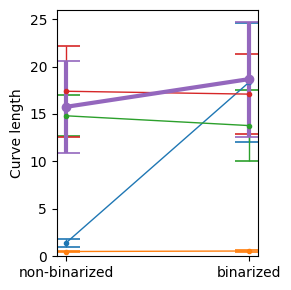

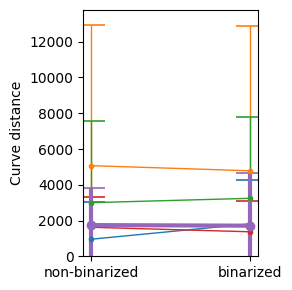

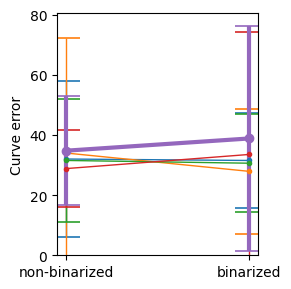

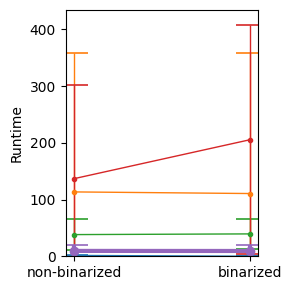

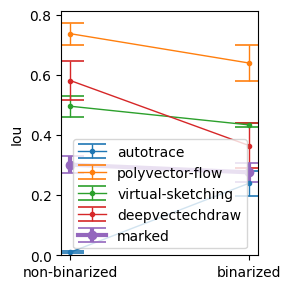

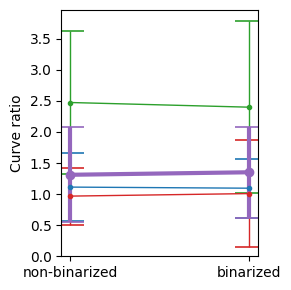

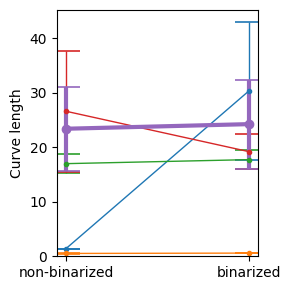

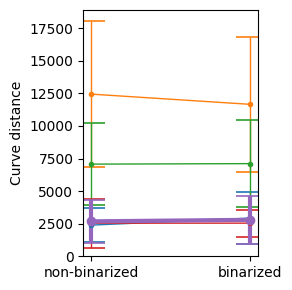

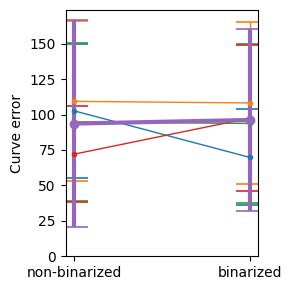

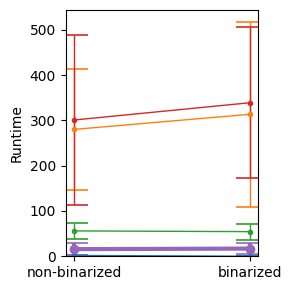

In [407]:
binarized = True
resolution = "1024-1.024"
for test_subset in test_subsets:
    for metric in summaries[test_subset][True][resolution][methods[0]].keys():
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot()
        for method in methods:
            if metric == "curve ratio" and method == "polyvector-flow":
                ax.plot([], label=method)
                continue
            plot_marked_binarization_metric(ax, metric, test_subset, method, resolution=resolution)
        ax.set_ylabel(metric.capitalize())
        ax.set_ylim(bottom=0)
        if metric == "iou":
            ax.legend()
        fig.tight_layout()
        fig.savefig(join(figures, f"{metric}_{binarized}_{resolution}_{test_subset}.pdf"))

tonari iou autotrace MannwhitneyuResult(statistic=45.0, pvalue=3.41531183136026e-08)
tonari iou polyvector-flow MannwhitneyuResult(statistic=8.0, pvalue=1.637140853715411e-09)
tonari iou virtual-sketching MannwhitneyuResult(statistic=0.0, pvalue=3.030868359795783e-10)
tonari iou deepvectechdraw MannwhitneyuResult(statistic=73.0, pvalue=4.793750445838785e-07)
tonari iou marked MannwhitneyuResult(statistic=194.0, pvalue=0.5130800796227113)
tonari curve ratio autotrace MannwhitneyuResult(statistic=119.0, pvalue=0.011062138508318366)
tonari curve ratio virtual-sketching MannwhitneyuResult(statistic=99.0, pvalue=0.002335757906125647)
tonari curve ratio deepvectechdraw MannwhitneyuResult(statistic=77.0, pvalue=0.00032157358682115576)
tonari curve ratio marked MannwhitneyuResult(statistic=230.5, pvalue=0.8111139459191504)
tonari curve length autotrace MannwhitneyuResult(statistic=254.5, pvalue=0.3993674708644893)
tonari curve length polyvector-flow MannwhitneyuResult(statistic=400.0, pvalue=6

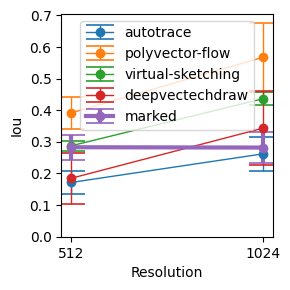

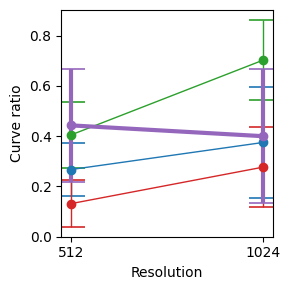

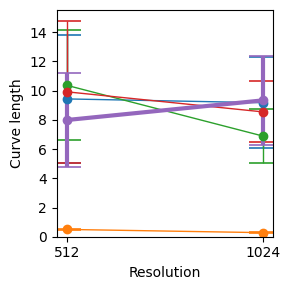

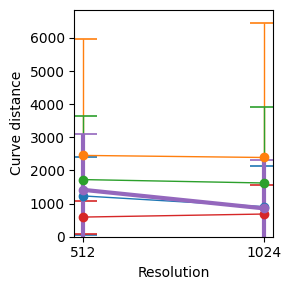

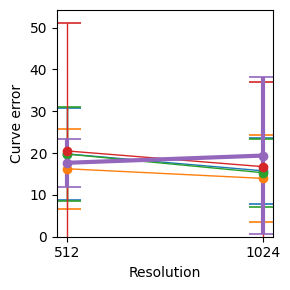

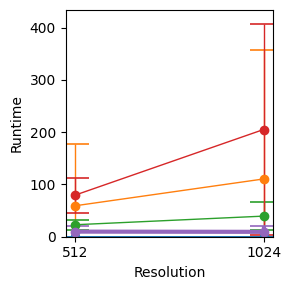

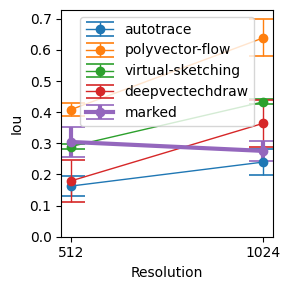

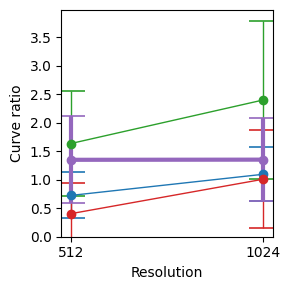

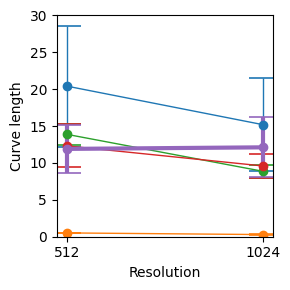

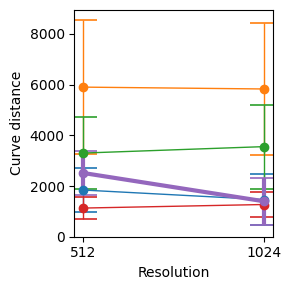

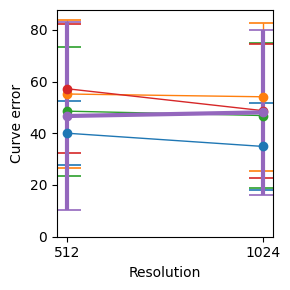

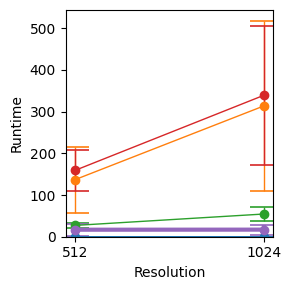

In [408]:
for test_subset in test_subsets:
    binarized = True
    resolution = "1024-1.024"
    for metric in summaries[test_subset][binarized][resolution][methods[0]].keys():
        fig = plt.figure(figsize=(3,3))
        ax = fig.add_subplot()
        for method in methods:
            if metric == "curve ratio" and method == "polyvector-flow":
                ax.plot([], label=method)
                continue
            plot_marked_res_metric(ax, metric, test_subset, method, binarized=binarized, normalize_res=metric in ["curve distance", "curve error", "curve length"])
        ax.set_ylabel(metric.capitalize())
        ax.set_xlabel("Resolution")
        ax.set_ylim(bottom=0)
        if metric == "iou":
            ax.legend()
        fig.tight_layout()
        fig.savefig(join(figures, f"{metric}_{resolution}_{binarized}_{test_subset}.pdf"))

In [14]:
method = "marked"
binarized = True
resolution = resolutions[0]
test_subset = test_subsets[0]

In [51]:
svg_dir = join(output_dir, method, "svg", "binarized" if binarized else "", resolution)
svg_file = join(svg_dir, test_subset + "-black_42.svg")
png_files = sorted(iglob(join(svg_dir, test_subset + "-*.png")))
gt_svg_file = svg_file.replace(method, "ground-truth")
png_file = svg_file.replace(".svg", ".png")
gt_png_file = png_file.replace(method, "ground-truth")
curves = extract_curves_from_svg(svg_file)
gt_curves = extract_curves_from_svg(gt_svg_file)

ShapiroResult(statistic=0.7549239993095398, pvalue=0.00014491639740299433)


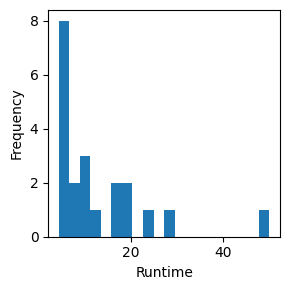

In [66]:
runtime = get_runtimes(method, test_subset, resolution, binarized)
print(shapiro(runtime))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(runtime, bins=20)
ax.set_xlabel("Runtime")
# plt.xlim(0, 100)
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "runtime.pdf"))

ShapiroResult(statistic=0.6502851247787476, pvalue=1.6322021455318148e-34)


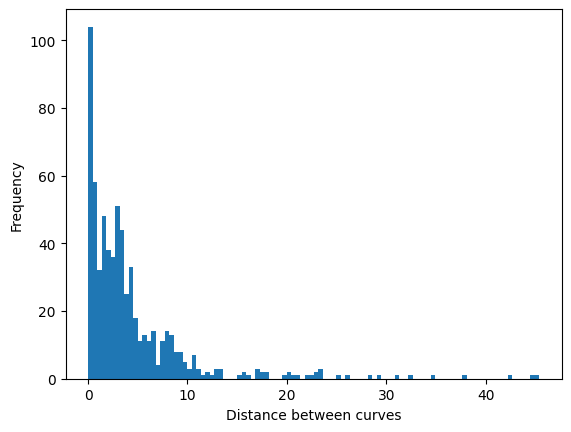

In [24]:
gt_min_dist = get_hole_distance(gt_curves)
print(shapiro(gt_min_dist))
plt.hist(gt_min_dist, bins=100)
plt.xlabel("Distance between curves")
plt.ylabel("Frequency")
plt.savefig(join(figures, "gt_min_dist.pdf"))

ShapiroResult(statistic=0.7527766823768616, pvalue=7.854034679751249e-21)


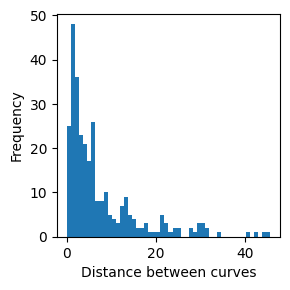

In [62]:
min_dist = get_hole_distance(curves)
print(shapiro(min_dist))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(min_dist, bins=50)
ax.set_xlabel("Distance between curves")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "min_dist.pdf"))

ShapiroResult(statistic=0.5895770788192749, pvalue=2.419612811495749e-26)


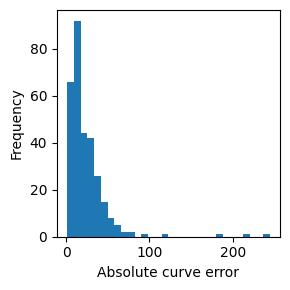

In [59]:
curve_error = get_curve_error(curves, gt_curves)
print(shapiro(curve_error))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(curve_error, bins=30)
ax.set_xlabel("Absolute curve error")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "curve_error.pdf"))

ShapiroResult(statistic=0.9180275201797485, pvalue=6.4724601546439775e-12)


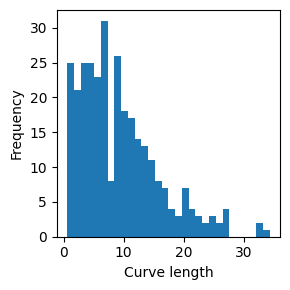

In [61]:
curve_length = [c.length() for c in curves]
print(shapiro(curve_length))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(curve_length, bins=30)
ax.set_xlabel("Curve length")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "curve_length.pdf"))

ShapiroResult(statistic=0.6754986047744751, pvalue=1.384077677357709e-05)


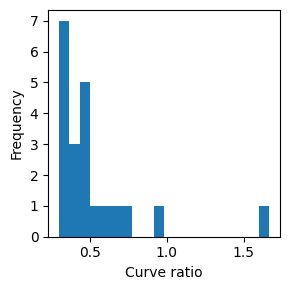

In [63]:
curve_ratio = []
for svg_file in iglob(join(svg_dir, test_subset + "*.svg")):
    gt_svg_file = svg_file.replace("marked", "ground-truth")
    curves = extract_curves_from_svg(svg_file)
    gt_curves = extract_curves_from_svg(gt_svg_file)
    curve_ratio.append(len(curves) / len(gt_curves))
print(shapiro(curve_ratio))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(curve_ratio, bins=20)
ax.set_xlabel("Curve ratio")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "curve_ratio.pdf"))

ShapiroResult(statistic=0.955660343170166, pvalue=0.43336915969848633)


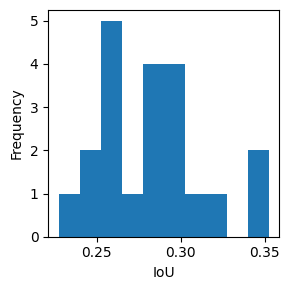

In [64]:
raster_dist = []
for png_file in png_files:
    gt_png_file = png_file.replace(method, "ground-truth")
    raster_dist.append(get_raster_difference(png_file, gt_png_file))
print(shapiro(raster_dist))
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot()
ax.hist(raster_dist)
ax.set_xlabel("IoU")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(join(figures, "raster_dist.pdf"))

For the following, run both the onnx and the normal pytorch model (.ckpt file) and place the resulting runtime info in `../output_runtime`.

In [136]:
output_runtime = "../outputs_runtime"
methods_runtime = ["torch", "onnx"]
resolution_runtime = "512-0.512"
binarized_runtime = False
runtime_stats = {}
runtime_summary = {}
for test_subset in test_subsets:
    runtime_stats[test_subset] = {}
    runtime_summary[test_subset] = {}
    for method in methods_runtime:
        runtimes = get_runtimes(method, test_subset, resolution_runtime, binarized_runtime, output_dir=output_runtime)
        runtime_stats[test_subset][method] = runtimes
        median_runtime = np.median(runtimes)
        if method == "onnx":
            method = "\\acrshort{onnx}"
            if mannwhitneyu(runtimes, runtime_stats[test_subset]["torch"]).pvalue < p:
                median_runtime = "\\underline{" + str(median_runtime) + "}"
        runtime_summary[test_subset].update({
            (method, "median"): median_runtime,
            (method, "\\acrshort{iqr}"): iqr(runtimes),
        })
        

In [137]:
columns = pd.MultiIndex.from_tuples(runtime_summary[list(runtime_summary.keys())[0]].keys())
df = pd.DataFrame.from_dict(runtime_summary, orient="index", columns=columns)
df.index.name = "subset"
with open(join(tables, "runtime-comparison.tex"), "w") as tex_file:
    df.to_latex(buf=tex_file, float_format="%.2f", multicolumn_format="c")
df

torch                   \acrshort{onnx}               
            median \acrshort{iqr}             median \acrshort{iqr}
subset                                                             
tonari       26.06          38.76   \underline{9.49}         13.175
sketchbench  46.93          36.16  \underline{15.83}         16.140